# ECG Classification
This notebook contain all the code necessary to handle data, define model and train it, and run tests. It uses data from MIT-BIH dataset (available online) and follows [1] for model definition and some hyper parameters selection.

One note is that notebooks are not intended for this purpose. It is well suited for short lines of code and displaying and transferring information between developers and users. For best results, define .py files and run experiments through console. 

[1] Kachuee, Mohammad, Shayan Fazeli, and Majid Sarrafzadeh. "Ecg heartbeat classification: A deep transferable representation." 2018 IEEE International Conference on Healthcare Informatics (ICHI). IEEE, 2018.

## Preliminary work
We first import all packages required for this code to work. As always, we use PyTorch.
We set manual randomization seeds to negate randomness between running. This makes random number generators predictable (but still random).


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from scipy.signal import resample
import random
np.random.seed(42)

import torch
import torch.nn as nn
from torch.optim import Adam

torch.manual_seed(42)
torch.backends.cudnn.benchmark = False

The following code will make graphs a bit easier to read and display.

In [ ]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'axes.grid':True,
         'axes.grid.which':'both'
         }
plt.rcParams.update(params)

## Read Dataset
The default dataset comes in two sets - Training set and Testing set. We combine the two and redistribute to three sets.

In [ ]:
df = pd.read_csv("../input/mitbih_train.csv", header=None)
df2 = pd.read_csv("../input/mitbih_test.csv", header=None)
# df = pd.concat([df, df2], axis=0)
df = df.reset_index().drop('index', axis='columns')

It is a good idea to look at the distribution of the data before working with it.

In [ ]:
df.describe().T

We take note of the following:
- All the fields are between  0 and 1.
- The last fields are mostly zeros.
- count is always the same number. We deduce that there are no missing values.
- The last row has a maximum of 4.... A look at the paper tells us that this is the target field. It is categorical with 4 categories:


In [ ]:
label_names = {0 : 'N',
              1: 'S',
              2: 'V',
              3: 'F',
              4 : 'Q'}

For more detailed analysis of the categories, please refer to the paper.

In [ ]:
df.info()

In [ ]:
# show some data
for _ in range(3):
    plt.figure()
    sample = df.sample(1).values.flatten()
    y = label_names[sample[-1]]
    plt.plot(sample[:-1])
    t = plt.title(y)

## Distribution of labels

In [ ]:
label=df[187].value_counts()
label

In [ ]:
label.rename(label_names).plot.bar()

In [ ]:
label=df2[187].value_counts()
label

In [ ]:
label.rename(label_names).plot.bar()

## Data augmentation

To train properly the model, we sould have to augment all data to the same level. We define two augmentations and wrapper classes for easy use.
Note that the augmentations are randomly random - so we get two levels of randomness in new input generation.

In [ ]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor


class Stretch:
    def __init__(self):
        pass
    
    def __call__(self,x):
        return stretch(x)
    
    def __repr__(self):
        return 'Stretch'
    
class Amplify:
    def __init__(self):
        pass
    
    def __call__(self,x):
        return amplify(x)
    
    def __repr__(self):
        return 'Amplify'

class Augment:
    def __init__(self, augmentation_list, return_prints = False):
        self.augmentation_list = augmentation_list
        self.return_prints = return_prints
        
    def __call__(self, x):
        augmentations_performed = ''
        
        for augmentation in self.augmentation_list:
            if np.random.binomial(1, 0.5) == 1:
                x = augmentation(x)
                augmentations_performed += f'{augmentation} '
                
        if not self.return_prints:
            return x
        return x, augmentations_performed



Lets look at the augmentations... In blue the original. In orange the augmented. It is always a good idea to know what the input is to the network exactly.

In [ ]:
augment = Augment([Amplify(), Stretch()], True)
for _ in range(5):
    plt.figure()
    sample = df.sample(1).values.flatten()
    y = label_names[sample[-1]]
    plt.plot(sample[:-1])
    
    augmented, augmentations_performed = augment(sample[:-1])
    plt.plot(augmented[:-1])
    
    title = plt.title(y + ' ' + augmentations_performed)

## Split Dataset into Train-, Validation- and Test-set

Next we devide the data to three sets - train set, validation set and test set - but we do so such that the probability of every class in each set is similar to the probability in the undivided set.

In [ ]:
from sklearn.model_selection import train_test_split

# train_df, test_val_df = train_test_split(df, train_size=0.9, stratify=df.iloc[:,-1])
# val_df, test_df = train_test_split(test_val_df, test_size=0.5, stratify=test_val_df.iloc[:,-1])

train_df, val_df = train_test_split(df, train_size=0.8, stratify=df.iloc[:,-1])
test_df = df2
# Make sure the target distribution stays the same...
for temp_df in [train_df, val_df, test_df]:
    print(temp_df.shape[0], temp_df.shape[0] / df.shape[0])
    print(temp_df.iloc[:,-1].value_counts(normalize=True))
    print('\n')

Note the probabilities! 

### Undersample the over-represented
There is a huge imbalance. The model can easily diminish the loss by ignoring everything other than class 0.
There are several ways to handle this - oversample, undersample, bootstrapping etc.
First, we look at the distribution of samples in the training set:

In [ ]:
col = train_df.groupby(187).size()
(col / col.sum()).plot.bar()
col

Next we take the over represented class (N) and sample 5000 samples, randomly. These will be used for training and the rest are ignored.

In [ ]:
non_normal_rows = train_df.loc[train_df.iloc[:,-1] != 0]
normal_rows = train_df.loc[train_df.iloc[:,-1] == 0].sample(5000)

train_df = non_normal_rows.append(normal_rows)

col = train_df.groupby(187).size()
(col / col.sum()).plot.bar()
col


## Build Model
We model the network from the article:

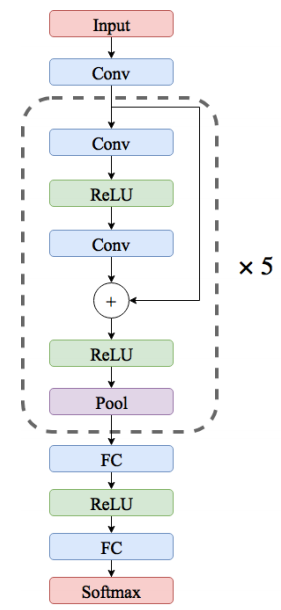

In code, it looks like this:

In [ ]:
class A(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.intro_bn = nn.BatchNorm1d(32)
    
        self.C11 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.A11 = nn.ReLU()
        self.C12 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.A12 = nn.ReLU()
        self.M11 = nn.MaxPool1d(kernel_size=5, stride=2)

    def forward(self, x):
        x = self.intro_bn(x)
        C = x
        x = self.C11(x)
        x = self.A11(x)
        x = self.C12(x)
        x = x + C
        x = self.A12(x)
        x = self.M11(x)
        
        return x
    
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_in = nn.Conv1d(1, 32, kernel_size=5)
        
        self.A_blocks = nn.ModuleList(A() for i in range(5))
        
        self.avg_pool = nn.AvgPool1d(2)
        self.fc1 = nn.Linear(32,32)
        self.acc1 = nn.ReLU()
        self.fc2 = nn.Linear(32,5)
        
    def forward(self, x):
        x = self.conv_in(x)
        
        for i in range(5):
            x = self.A_blocks[i](x)
        
        x = self.avg_pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.acc1(x)
        x = self.fc2(x)
        
        return x
    

For convenience, we define the recurring module as "A" and use it as a list of modules in the Model class.
Now for the hyperparameters. These are chosen by the developer according to the performance on the validation set.

In [ ]:
batch_size = 256
epochs = 10 # 75
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_splits = 7

Notice the Use of 'cuda': this is the driver connecting us to the graphical processing unit (GPU). Moving a model to the GPU means that it uses the GPU memory and that any operation done will be done by the GPU (not the CPU). Any mathematical operation between two variables requires the two to be on the same device - RAM or GPU RAM.

Now we define helper methods for data handling. These will be very helpfull to divide the data to batches, shuffle and randomize and do computations in parallel. Since this is very pytorch-specific, there is no need to dive into it.

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ds(Dataset):
  def __init__(self, x, y=None, transforms=None):
    super().__init__()

    self.X = x
    self.Y = y
    self.transforms = transforms

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self,idx):
    x = self.X.iloc[idx,:]
    
    if self.transforms is not None:
        x = self.transforms(x)

    if self.Y is not None:
      return torch.Tensor(x).view(1,-1).float(), torch.Tensor([self.Y.iloc[idx]]).float().squeeze()

    return torch.Tensor(x).float()

augment = Augment([Amplify(), Stretch()])

train_set = ds(train_df.iloc[:,:-1], train_df.iloc[:,-1], transforms=augment)
val_set = ds(val_df.iloc[:,:-1], val_df.iloc[:,-1])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size*4)

Note we take special care to not accidently send the label to the model (column -1).

## Train Model
All that remains is to define the model (and transfer it to the right device), an optimizer and train.

In [ ]:
# model = Model().to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

from torch.optim.lr_scheduler import ReduceLROnPlateau
# lr_sched = ReduceLROnPlateau(optimizer, patience=3) # None for a manual LR regimen

Here we use Adam optimizer, which converges faster better than SGD. The learning rate is defined ahead.


In [ ]:
epoch_train_losses = []
epoch_val_losses = []

from sklearn.model_selection import KFold
kf = KFold(n_splits=n_splits)
for fold_n, (train_idx, val_idx) in enumerate(kf.split(df)):
    train_set = ds(df.iloc[train_idx,:-1], df.iloc[train_idx,-1], transforms=augment)
    val_set = ds(df.iloc[val_idx,:-1], df.iloc[val_idx,-1])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size*4)
    
    model = Model().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    lr_sched = ReduceLROnPlateau(optimizer, patience=3)
    for epoch in range(epochs):
        epoch_train_loss = 0
        epoch_val_loss = 0

        model.train()
        for batch_id, (x,y_true) in enumerate(train_loader):
            y_pred = model(x.to(device))

            optimizer.zero_grad()
            loss = criterion(y_pred, y_true.long().to(device))
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() / len(train_loader)

        model.eval()
        with torch.no_grad():
            for batch_id, (x,y_true) in enumerate(val_loader):
                y_pred = model(x.to(device))
                loss = criterion(y_pred, y_true.long().to(device))

                epoch_val_loss += loss.item() / len(val_loader)


        epoch_train_losses.append(epoch_train_loss)
        epoch_val_losses.append(epoch_val_loss)
        print(f'Fold {fold_n} Epoch {epoch}:\tTrain loss: {epoch_train_loss:0.2e}\tVal loss: {epoch_val_loss:0.2e} \tLR: {optimizer.param_groups[0]["lr"]:0.2e}')

        if lr_sched is None:
            if epoch % 10 == 0 and epoch > 0:
                optimizer.param_groups[0]['lr'] /= 10
                print(f'Reducing LR to {optimizer.param_groups[0]["lr"]}')
        else:
            lr_sched.step(epoch_val_loss)
    torch.save(model.state_dict(), f'model_fold_{fold_n}.pth')


Notice we decrease the learning rate throughout training. Learning rate modulation is an active area of research. 

Lets see what we got.

In [ ]:
plt.plot(np.arange(len(epoch_train_losses)), epoch_train_losses)
plt.plot(np.arange(len(epoch_val_losses)), epoch_val_losses)
plt.legend(['training loss','validation loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')

We should see the loss converge. The training set loss should be monotone (though it colud be not). Some amount of overfit is acceptable, but wometimes we need to use some ragularization (that was not used here).

## Test the model - Validation set

Up until now we discussed loss - not actual performane. Now is the time to consider accuracy. We first examine the different metrics on the validation set. 

In [ ]:
predictions = []
labels = []

model.eval()
with torch.no_grad():
    for batch_id, (x,y_true) in enumerate(val_loader):
        y_pred = model(x.to(device)).argmax(1)
        
        predictions.extend(y_pred.squeeze().tolist())
        labels.extend(y_true.squeeze().tolist())
        
prediction_labels = pd.DataFrame(np.array([predictions, labels]).T, columns=['Prediction', 'Label'])
cm = prediction_labels.groupby(['Prediction', 'Label']).size()
cm.unstack(0)

In [ ]:
print(classification_report(predictions, labels))

## Test the model - Test set

In [ ]:
test_set = ds(test_df.iloc[:,:-1], test_df.iloc[:,-1])
test_loader = DataLoader(test_set, batch_size=batch_size*4, shuffle=False)

predictions = []

model.eval()
with torch.no_grad():
    for fold in range(n_splits):
        model = Model().to(device)
        model.load_state_dict(torch.load(f'model_fold_{fold}.pth'))
        model.eval()
        
        fold_predictions = []
        labels = []
        for batch_id, (x,y_true) in enumerate(test_loader):
            y_pred = model(x.to(device)).argmax(1)

            fold_predictions.extend(y_pred.squeeze().tolist())
            labels.extend(y_true.squeeze().tolist())
        predictions.append(fold_predictions)
    
predictions.append(labels)
all_prediction_labels = pd.DataFrame(
    np.array(predictions).T, 
    columns=[f'fold {n}' for n in range(n_splits)] + ['Label']
#     columns=['fold 0', 'fold 1', 'fold 2','fold 3','fold 4', 'Label'],
#     columns=['fold 0', 'fold 1', 'fold 3', 'Label']
)

final_predictions = all_prediction_labels.iloc[:,:-1].mode(1).iloc[:,0]
prediction_labels = pd.DataFrame(
    np.hstack([
        final_predictions.values.reshape(-1,1), 
        all_prediction_labels.loc[:,'Label'].values.reshape(-1,1)]
    ),
    columns=['Prediction', 'Label']
)
prediction_labels

cm = prediction_labels.groupby(['Prediction', 'Label']).size()
cm.unstack(0)

In [ ]:
predictions = prediction_labels.loc[:,'Prediction'].values
labels = prediction_labels.loc[:,'Label'].values
print(classification_report(predictions, labels))